In [1]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from IPython.display import  display
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
import tensorflow as tf
import matplotlib.cm as cm
import os
import matplotlib.pyplot as plt

In [ ]:
#code is written using codes from: 
#https://gist.github.com/RaphaelMeudec/e9a805fa82880876f8d89766f0690b54
#https://keras.io/examples/vision/grad_cam/

In [2]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)

In [3]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

#BATCH_SIZE = 32
#IMG_SIZE = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [4]:
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE, include_top=False,
                                               weights='imagenet')

In [5]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [6]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


In [7]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [8]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 2048)


In [9]:
base_model.trainable = False

In [10]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [11]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [12]:
inputs = tf.keras.Input(shape=(224, 224, 3))
#x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [13]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0     

In [15]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 10s 229ms/step - loss: 0.9035 - accuracy: 0.4715


In [16]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.90
initial accuracy: 0.47


In [17]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 24s 315ms/step - loss: 0.7028 - accuracy: 0.5865 - val_loss: 0.4765 - val_accuracy: 0.7413
Epoch 2/10
63/63 [==============================] - 19s 304ms/step - loss: 0.4295 - accuracy: 0.7910 - val_loss: 0.2972 - val_accuracy: 0.8960
Epoch 3/10
63/63 [==============================] - 20s 306ms/step - loss: 0.2946 - accuracy: 0.8800 - val_loss: 0.2127 - val_accuracy: 0.9418
Epoch 4/10
63/63 [==============================] - 20s 306ms/step - loss: 0.2227 - accuracy: 0.9305 - val_loss: 0.1674 - val_accuracy: 0.9554
Epoch 5/10
63/63 [==============================] - 20s 307ms/step - loss: 0.1825 - accuracy: 0.9385 - val_loss: 0.1356 - val_accuracy: 0.9641
Epoch 6/10
63/63 [==============================] - 20s 306ms/step - loss: 0.1512 - accuracy: 0.9520 - val_loss: 0.1151 - val_accuracy: 0.9703
Epoch 7/10
63/63 [==============================] - 20s 307ms/step - loss: 0.1288 - accuracy: 0.9620 - val_loss: 0.1008 - val_accuracy: 0.9777

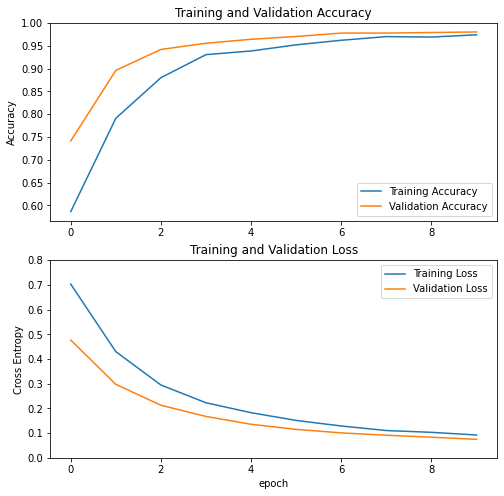

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
import matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,0.8])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [19]:
base_model.trainable = True

In [20]:
# Broj slojeva u baznom modelu
print("Broj slojeva u baznom modelu: ", len(base_model.layers))

# Fine-tune od ovog sloja naviše
fine_tune_at = 100

# Zamrzni sve slojeve prije `fine_tune_at` sloja
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Broj slojeva u baznom modelu:  175


In [21]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0     

In [23]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 41s 509ms/step - loss: 0.0462 - accuracy: 0.9850 - val_loss: 0.0295 - val_accuracy: 0.9851
Epoch 11/20
63/63 [==============================] - 31s 489ms/step - loss: 0.0029 - accuracy: 0.9995 - val_loss: 0.0446 - val_accuracy: 0.9876
Epoch 12/20
63/63 [==============================] - 31s 493ms/step - loss: 4.3413e-04 - accuracy: 1.0000 - val_loss: 0.0357 - val_accuracy: 0.9864
Epoch 13/20
63/63 [==============================] - 31s 491ms/step - loss: 3.7374e-05 - accuracy: 1.0000 - val_loss: 0.0491 - val_accuracy: 0.9864
Epoch 14/20
63/63 [==============================] - 31s 489ms/step - loss: 3.6168e-06 - accuracy: 1.0000 - val_loss: 0.0638 - val_accuracy: 0.9839
Epoch 15/20
63/63 [==============================] - 31s 487ms/step - loss: 4.0271e-07 - accuracy: 1.0000 - val_loss: 0.0553 - val_accuracy: 0.9889
Epoch 16/20
63/63 [==============================] - 31s 489ms/step - loss: 0.0013 - accuracy: 0.9995 - val_loss: 0.0667

In [24]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

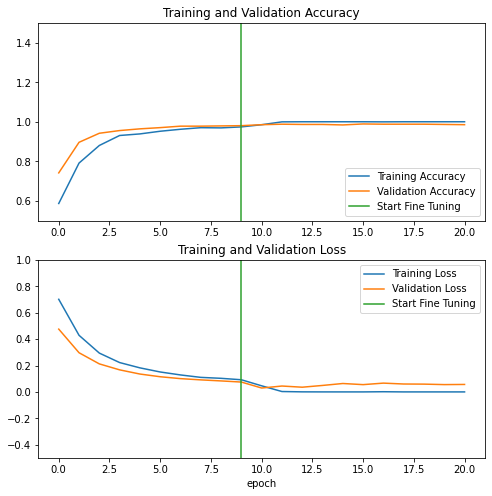

In [25]:
import matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1.5])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([-0.5, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [26]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 2s 232ms/step - loss: 0.0135 - accuracy: 0.9948
Test accuracy : 0.9947916865348816


In [30]:
from google.colab import drive
drive.mount('//content//gdrive')

Mounted at //content//gdrive


Predictions:
 [0 1 0 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 0 1 0 1 1 1 1 0 0 1 0 0 0 1]
Labels:
 [0 1 0 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 0 1 0 1 1 1 1 0 0 1 0 0 0 1]


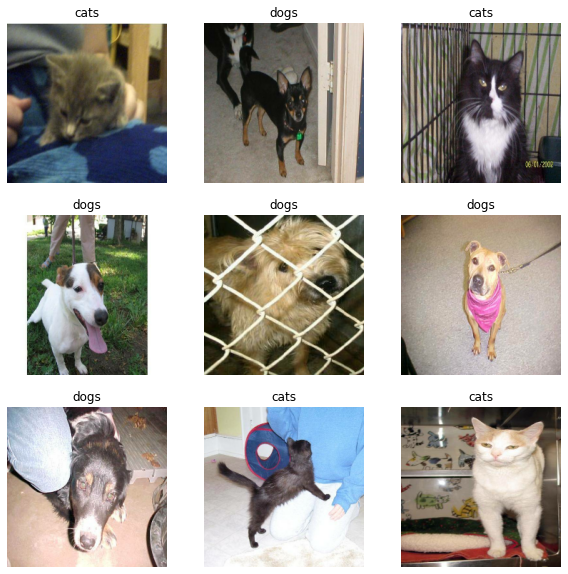

In [29]:
class_names = train_dataset.class_names
# Preuzmi seriju slika iz skupa za testiranje
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Primijeni sigmoidalnu fju pošto naš model vraća logičke vr
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [51]:
#img_path='/content/gdrive/MyDrive/KV_domaci2/dog.2491.jpg'
img_path='/content/gdrive/MyDrive/KV_domaci2/Cats Dogs izvestaj/dog.2111.jpg'


In [52]:
import cv2
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img = tf.keras.preprocessing.image.img_to_array(img)

In [53]:
CAT_CLASS_INDEX = None
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img = tf.keras.preprocessing.image.img_to_array(img)

#LAYER_NAME='conv5_block3_out'
LAYER_NAME='conv5_block3_3_conv'



grad_model = tf.keras.models.Model([base_model.inputs], [base_model.get_layer(LAYER_NAME).output, base_model.output])

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(np.array([img]))
    loss = predictions[:, CAT_CLASS_INDEX]

output = conv_outputs[0]
grads = tape.gradient(loss, conv_outputs)[0]

gate_f = tf.cast(output > 0, 'float32')
gate_r = tf.cast(grads > 0, 'float32')
guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

weights = tf.reduce_mean(guided_grads, axis=(0, 1))

cam = np.ones(output.shape[0: 2], dtype = np.float32)

for i, w in enumerate(weights):
    cam += w * output[:, :, i]

cam = cv2.resize(cam.numpy(), (224, 224))
cam = np.maximum(cam, 0)
heatmap = (cam - cam.min()) / (cam.max() - cam.min())

cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

output_image = cv2.addWeighted(cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR), 0.5, cam, 1, 0)

cv2.imwrite('cam.png', output_image)

True

In [54]:
# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

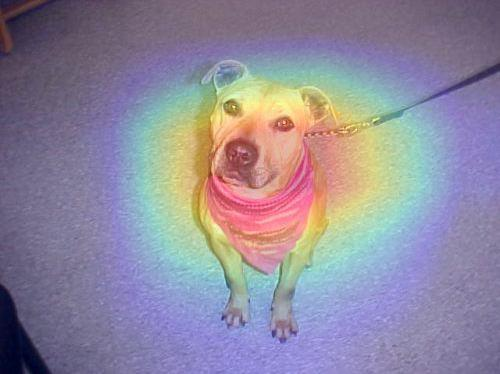

In [55]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)